In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from xgboost import plot_importance

from matplotlib import pyplot
%matplotlib inline
sns.set(color_codes=True)
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
wine=pd.read_csv('wine_with_bands.csv')

In [3]:
wine.head()

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality,fixed.acidity_band,volatile.acidity_band,citric.acid_band,residual.sugar_band,chlorides_band,free.sulfur.dioxide_band,total.sulfur.dioxide_band,density_band,pH_band,sulphates_band,alcohol_band,badtag
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,3,8,0,2,3,3,4,7,8,2,1,1.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,4,9,0,7,8,8,7,5,2,6,3,1.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,4,9,1,5,7,5,6,5,3,5,3,1.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,9,0,9,2,3,6,7,7,1,3,3,0.0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,3,8,0,2,3,3,4,7,8,2,1,1.0


In [4]:
wine.shape

(1599, 24)

In [5]:
var_band=[i for i in wine.columns.values if i.endswith('_band')]

In [6]:
orig_ban = [i for i in wine.columns.values if i not in var_band]

In [7]:
orig_ban

['fixed.acidity',
 'volatile.acidity',
 'citric.acid',
 'residual.sugar',
 'chlorides',
 'free.sulfur.dioxide',
 'total.sulfur.dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'quality',
 'badtag']

In [8]:
var_band

['fixed.acidity_band',
 'volatile.acidity_band',
 'citric.acid_band',
 'residual.sugar_band',
 'chlorides_band',
 'free.sulfur.dioxide_band',
 'total.sulfur.dioxide_band',
 'density_band',
 'pH_band',
 'sulphates_band',
 'alcohol_band']

# Calculation of Weight of evidence

In [9]:
def calculate_woe(input_df,badtag,woe_varlist):
    total_pop=input_df.shape[0]
    bads=input_df.groupby(badtag)[badtag].sum()
    goods=total_pop-bads
    
    return[find_woe_variable(input_df,var,total_pop,bads,goods) for var in woe_variable_list]

In [10]:
def woe_feature(x,y,event):
    #X: numpy array of first feature
    #y:numpy array of target variable
    
    ev_total,no_ev_total=event_count(y,event)
    x_lab=np.unique(x)
    woe_dict={}
    
    for x1 in x_lab:
        y1=y[np.where(x==x1)[0]]
        ev_count,no_ev_count=event_count(y1,event)
        rate_event=1.0*ev_count/ev_total
        rate_non_event=1.0*no_ev_count/ev_total
        
        if rate_event==0:
            rate_event=-50
        elif rate_non_event==0:
            rate_non_event=50
        else:
            woe1=math.log(rate_event/rate_non_event)
            
        woe_dict[x1]=woe1
        
    return woe_dict

def event_count(a,event=1):
    event_count=(a==event).sum()
    non_event_count=a.shape[-1]-event_count
    return event_count,non_event_count

def find_append_woe(df,column_name,target):
   
    print('processing',column_name)

    woe_dict_1=woe_feature(df[column_name],df[target].values,1)
    woe_array=np.array([woe_dict_1])
    new_col_df=pd.DataFrame()
    new_col_df[column_name]=df[column_name]
    new_col_df[column_name +'_woe']=new_col_df[column_name].replace(woe_array[0])
    del(new_col_df[column_name])
    df=pd.concat([df,new_col_df],axis=1)
    return df

def loop_woe(df,cols):
    target='badtag'
    
    for col in cols:
        df=find_append_woe(df,col,target)
        
    return df


In [11]:

df=loop_woe(wine,var_band)

processing fixed.acidity_band
processing volatile.acidity_band
processing citric.acid_band
processing residual.sugar_band
processing chlorides_band
processing free.sulfur.dioxide_band
processing total.sulfur.dioxide_band
processing density_band
processing pH_band
processing sulphates_band
processing alcohol_band


# Model for wine

In [12]:
var_to_train=[i for i in df.columns.values if i.endswith('_band_woe')]

In [13]:
var_to_train

['fixed.acidity_band_woe',
 'volatile.acidity_band_woe',
 'citric.acid_band_woe',
 'residual.sugar_band_woe',
 'chlorides_band_woe',
 'free.sulfur.dioxide_band_woe',
 'total.sulfur.dioxide_band_woe',
 'density_band_woe',
 'pH_band_woe',
 'sulphates_band_woe',
 'alcohol_band_woe']

In [14]:
orig_var = [i for i in orig_ban if i not in ['badtag','quality']]

In [15]:
orig_var

['fixed.acidity',
 'volatile.acidity',
 'citric.acid',
 'residual.sugar',
 'chlorides',
 'free.sulfur.dioxide',
 'total.sulfur.dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

In [16]:
woe_df = df[var_to_train]
orig_df = df[orig_var]
y_woe = df['badtag']
y_orig_df = df['badtag']

In [84]:

X_train, X_test, y_train, y_test = train_test_split(
    woe_df, y_woe, test_size=0.35, random_state=20)   

In [86]:

orig_train, orig_test, y_train_or, y_test_or = train_test_split(
    orig_df,y_orig_df, test_size=0.35, random_state=20)   

Here we made two train and test set one is X_train which contain weight of evidence variables and the one which do not contain any modified features,just the given features

In [87]:
orig_train.head(2)

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol
1196,7.9,0.58,0.23,2.3,0.076,23.0,94.0,0.99686,3.21,0.58,9.5
413,9.9,0.40,0.53,6.7,0.097,6.0,19.0,0.99860,3.27,0.82,11.7


## Logistic Regression Model

In [88]:
lr=LogisticRegression()
lr.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [89]:
lr_orig = LogisticRegression()
lr_orig.fit(orig_train,y_train_or)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [90]:
pred=lr.predict(X_test)
pred_orig = lr_orig.predict(orig_test)

In [91]:
lr.score(X_train, y_train)

0.7718960538979788

In [92]:
lr.score(X_test,y_test)

0.7732142857142857

The almost similar accuracy ensure that our model is giving a good validation accuracy.

In [118]:
lr_orig.score(orig_train,y_train_or)

0.7516843118383061

In [119]:
lr_orig.score(orig_test,y_test_or)

0.7482142857142857

The accuracy from the original features is way less than weight of evidences features.Now we will check whether our model is stabel or not by checking classification reports and cross val scores


In [120]:
from sklearn import metrics
print(metrics.confusion_matrix(y_test, pred))
print(metrics.classification_report(y_test, pred))

[[239  64]
 [ 63 194]]
             precision    recall  f1-score   support

        0.0       0.79      0.79      0.79       303
        1.0       0.75      0.75      0.75       257

avg / total       0.77      0.77      0.77       560



In [121]:
from sklearn import metrics
print(metrics.confusion_matrix(y_test, pred_orig))
print(metrics.classification_report(y_test, pred_orig))

[[225  78]
 [ 63 194]]
             precision    recall  f1-score   support

        0.0       0.78      0.74      0.76       303
        1.0       0.71      0.75      0.73       257

avg / total       0.75      0.75      0.75       560



The classification reports also looks good with respect to the original feature classification report.

In [122]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, pred).ravel()
print(tn,fp,fn,tp)

239 64 63 194


In [123]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, pred_orig).ravel()
print(tn,fp,fn,tp)

225 78 63 194


Our model with Weight of evidence features is able to detect more true negatives than the one with original features

In [124]:
probs = lr.predict_proba(X_test)

In [125]:
from sklearn.cross_validation import cross_val_score
from sklearn import cross_validation
# evaluate the model using 10-fold cross-validation
scores = cross_val_score(LogisticRegression(), X_train, y_train, scoring='accuracy', cv=10)

print(scores)
print(scores.mean())

[0.73333333 0.71428571 0.75961538 0.75961538 0.77884615 0.76923077
 0.75       0.81553398 0.75728155 0.77669903]
0.7614441303033536


Our model's cross validation results are also good ensuring stability in our model. 

## XgBoost Model

In [126]:
model=XGBClassifier()
model.fit(X_train,y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [127]:
y_pred=model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 75.89%


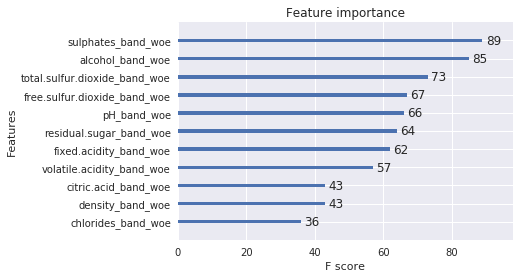

In [128]:
plot_importance(model)

In [129]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
print(tn,fp,fn,tp)

228 75 60 197


In [130]:
from sklearn import metrics
print(metrics.confusion_matrix(y_test, pred_orig))
print(metrics.classification_report(y_test, pred_orig))

[[225  78]
 [ 63 194]]
             precision    recall  f1-score   support

        0.0       0.78      0.74      0.76       303
        1.0       0.71      0.75      0.73       257

avg / total       0.75      0.75      0.75       560



In [131]:
from sklearn.cross_validation import cross_val_score
from sklearn import cross_validation
# evaluate the model using 10-fold cross-validation
scores = cross_val_score(XGBClassifier(), X_train, y_train, scoring='accuracy', cv=10)

print(scores)
print(scores.mean())

[0.74285714 0.76190476 0.78846154 0.75961538 0.76923077 0.79807692
 0.76923077 0.85436893 0.75728155 0.76699029]
0.7768018066076319


The XG boost classifier is not so stable as the logistic regression on Weight of evidence variables.Since the cross validation accuracy varies a lot.This model would not be considered as a stable model 

In [132]:
model_orig=XGBClassifier()
model_orig.fit(orig_train,y_train_or)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [133]:
y_pred_or=model_orig.predict(orig_test)
accuracy = accuracy_score(y_test_or, y_pred_or)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 75.36%


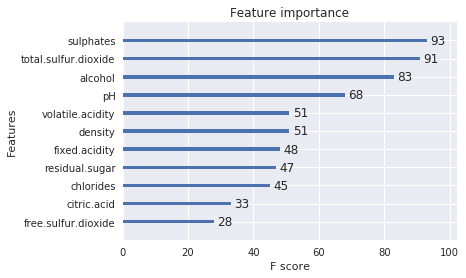

In [134]:
plot_importance(model_orig)

In [136]:
from sklearn.cross_validation import cross_val_score
from sklearn import cross_validation
# evaluate the model using 10-fold cross-validation
scores2 = cross_val_score(XGBClassifier(), orig_train, y_train_or, scoring='accuracy', cv=10)

print(scores2)
print(scores2.mean())

[0.72380952 0.76190476 0.74038462 0.75961538 0.79807692 0.76923077
 0.77884615 0.78640777 0.75728155 0.74757282]
0.7623130267790461


# Naive bayes Classifier

In [139]:
gnb = GaussianNB()

In [140]:
y_pred = gnb.fit(X_train,y_train).predict(X_test)

In [141]:
from sklearn.cross_validation import cross_val_score
from sklearn import cross_validation
# evaluate the model using 10-fold cross-validation
scores = cross_val_score(GaussianNB(), X_train, y_train, scoring='accuracy', cv=10)

print(scores)
print(scores.mean())

[0.71428571 0.74285714 0.75961538 0.70192308 0.73076923 0.75
 0.74038462 0.81553398 0.74757282 0.77669903]
0.7479640990077884


In [142]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 73.21%


In [143]:
from sklearn.cross_validation import cross_val_score
from sklearn import cross_validation
# evaluate the model using 10-fold cross-validation
scores = cross_val_score(GaussianNB(), orig_train, y_train_or, scoring='accuracy', cv=10)

print(scores)
print(scores.mean())

[0.73333333 0.66666667 0.71153846 0.73076923 0.71153846 0.76923077
 0.72115385 0.75728155 0.69902913 0.77669903]
0.7277240477968633


In [144]:
y_pred_orig = gnb.fit(orig_train,y_train_or).predict(orig_test)
accuracy = accuracy_score(y_test_or, y_pred_orig)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 72.86%


We can see from above results that a naive base classifier is not good for our problem statement.The cross validation scores as well accuracy are not upto mark as compared to logistic regression model and XGboost model